The goal of this project was to determine the best Machine Learning model inorder to predict the ‘product’ 
in the US Consumer Finance Complaints dataset based on the ‘consumer complaint narrative’.
The following classification models are used:
    - Linear Support Vector Machine (LinearSVM)
    - Random Forest
    - Multinomial Naive Bayes
    - Logistic Regression



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [2]:
df = pd.read_csv("/Users/alikazmi/Desktop/consumer_complaints.csv")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.sample(n=5)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
30941,01/26/2014,Student loan,Non-federal student loan,Can't repay my loan,Can't get flexible payment options,NaN,NaN,"Navient Solutions, Inc.",TX,79414,NaN,NaN,Web,01/26/2014,Closed with explanation,Yes,Yes,685962
79022,05/02/2014,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,"TransUnion Intermediate Holdings, Inc.",TX,76179,NaN,NaN,Web,05/02/2014,Closed with non-monetary relief,Yes,No,835020
451410,08/17/2012,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,HSBC North America Holdings Inc.,OH,45044,NaN,NaN,Referral,08/21/2012,Closed with explanation,Yes,No,137501
460509,01/28/2013,Credit card,NaN,Billing disputes,NaN,NaN,NaN,Barclays PLC,CA,95821,NaN,NaN,Web,01/29/2013,Closed with explanation,Yes,No,266553
536574,03/04/2014,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,NY,11572,NaN,NaN,Web,03/04/2014,Closed with explanation,Yes,Yes,741433


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [5]:
df = df[['product', 'consumer_complaint_narrative']]

In [6]:
df.isnull().sum()

product                              0
consumer_complaint_narrative    489151
dtype: int64

In [7]:
df = df[pd.notnull(df['consumer_complaint_narrative'])]

In [8]:
#Check for any blank complaints
blanks = []

for i,p,c in df.itertuples():
    if type(c) == str:
        if c.isspace():
            blanks.append(i)

In [9]:
blanks

[]

In [10]:
df['product'].unique()

array(['Debt collection', 'Consumer Loan', 'Mortgage', 'Credit card',
       'Credit reporting', 'Student loan', 'Bank account or service',
       'Payday loan', 'Money transfers', 'Other financial service',
       'Prepaid card'], dtype=object)

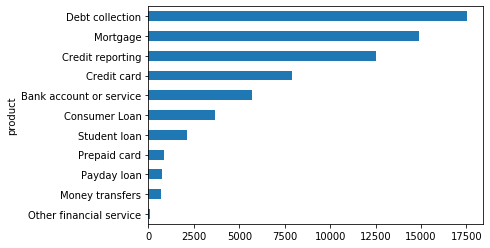

In [11]:
df.groupby('product').consumer_complaint_narrative.count().sort_values().plot.barh()

In [12]:
#Label encoding 
le = LabelEncoder()
df['product_id'] = le.fit_transform(df['product'])


In [13]:
df.head()

,product,consumer_complaint_narrative,product_id
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,4
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,1
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,6
190207,Mortgage,I have an open and current mortgage with Chase...,6
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,6


In [14]:
#Convert all complaints to lower case
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].str.lower()

In [15]:
#Tokenization and Stemming
from nltk.stem import PorterStemmer, WordNetLemmatizer
porter_stemmer = PorterStemmer()

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df['consumer_complaints'] = df['consumer_complaint_narrative'].apply(stem_sentences)

In [16]:
del df['consumer_complaint_narrative']

In [17]:
#Creating TFIDF model for consumer complaints narrative
vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words = 'english', max_features = 10000, ngram_range=(1,3) )
complaints = vectorizer.fit_transform(df['consumer_complaints']).toarray()
product_id = df.product_id

In [18]:
vectorizer.get_feature_names()

['00',
 '00 00',
 '00 account',
 '00 addit',
 '00 annual',
 '00 annual fee',
 '00 appli',
 '00 apprais',
 '00 ask',
 '00 balanc',
 '00 balance',
 '00 bank',
 '00 becaus',
 '00 card',
 '00 cash',
 '00 charg',
 '00 check',
 '00 check account',
 '00 close',
 '00 collect',
 '00 contact',
 '00 credit',
 '00 credit card',
 '00 current',
 '00 date',
 '00 day',
 '00 debt',
 '00 deposit',
 '00 did',
 '00 disput',
 '00 dollar',
 '00 dollars',
 '00 escrow',
 '00 everi',
 '00 fee',
 '00 ha',
 '00 includ',
 '00 instead',
 '00 just',
 '00 late',
 '00 late fee',
 '00 loan',
 '00 make',
 '00 money',
 '00 month',
 '00 month xxxx',
 '00 monthli',
 '00 mortgag',
 '00 need',
 '00 new',
 '00 onli',
 '00 origin',
 '00 overdraft',
 '00 overdraft fee',
 '00 owe',
 '00 paid',
 '00 past',
 '00 pay',
 '00 payment',
 '00 payment xxxx',
 '00 pleas',
 '00 plu',
 '00 princip',
 '00 purchas',
 '00 receiv',
 '00 report',
 '00 request',
 '00 return',
 '00 said',
 '00 sent',
 '00 servic',
 '00 sinc',
 '00 state',
 '00 t

In [19]:
complaints.shape

(66806, 10000)

In [20]:
#Train-Test Split
X = complaints
y = product_id

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state = 0)

In [21]:
#Logistic Regression
lr = LogisticRegression(solver='liblinear',multi_class='ovr')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)


0.8479193693244187

In [22]:
#SVM
svm = LinearSVC()
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.8547550144696138

In [23]:
#Random Forest
rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8083524598343479

In [24]:
#Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb.score(X_test, y_test)

0.7970262448857399

In [25]:
#Cross validation
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=3)

In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
#cross_val_score(LogisticRegression(solver = 'saga', max_iter = 100), complaints, product_id)

In [28]:
cross_val_score(LinearSVC(), complaints, product_id)

array([0.8328843 , 0.83631465, 0.84769104, 0.85375346, 0.84656837])

In [29]:
cross_val_score(RandomForestClassifier(n_estimators=40), complaints, product_id)

array([0.78880407, 0.79455131, 0.80166155, 0.80862211, 0.80959509])

In [30]:
cross_val_score(MultinomialNB(), complaints, product_id)

array([0.79830864, 0.79380286, 0.79949106, 0.80450565, 0.80607739])

In [35]:
#Using train-test split and cross validation, it is found that LinearSVC has the best accuracy. Therefore it will be further explored
#Confusion matrix displays relationship between actual and predicted values of the dependant variable.
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
predictions = svm.predict(X_test)
print (confusion_matrix(y_test, predictions))


[[1397   18  138   28   36   21   69    0    4   52    1]
 [  25  704   77   64  158    2   71    0   18    1    2]
 [  99   29 1971  119  162    5   24    0    2    6    3]
 [  12   25   74 3187  263    0   48    0    3    0   12]
 [  30   81  113  234 4624    1   91    0   27    2   40]
 [  33    1   16    4    9  130    7    0    0    3    0]
 [  42   29   19   56   72    0 4301    0    0    0    6]
 [   8    1    1    4    4    4    2    1    1    0    1]
 [  12   21    4    6   70    0   10    0   72    1    1]
 [  26    1   25    4    6    0    0    0    0  190    0]
 [   4   13    5   15   57    0   16    0    1    0  554]]


In [36]:
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1764
           1       0.76      0.63      0.69      1122
           2       0.81      0.81      0.81      2420
           3       0.86      0.88      0.87      3624
           4       0.85      0.88      0.86      5243
           5       0.80      0.64      0.71       203
           6       0.93      0.95      0.94      4525
           7       1.00      0.04      0.07        27
           8       0.56      0.37      0.44       197
           9       0.75      0.75      0.75       252
          10       0.89      0.83      0.86       665

    accuracy                           0.85     20042
   macro avg       0.82      0.69      0.71     20042
weighted avg       0.85      0.85      0.85     20042

